In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torch_pconv import PConv2d  # Partial convolution layer; ensure this is installed.

In [2]:
class DepthInpaintingDatasetCSV(Dataset):
    def __init__(self, csv_file, target_size=(240,320), mask_size=None, transform=None, apply_mask=True):
        self.data = pd.read_csv(csv_file, header=None)
        self.color_paths = self.data.iloc[:, 0].tolist()
        self.depth_paths = self.data.iloc[:, 1].tolist()
        self.target_size = target_size        # For depth target (and mask): e.g. (240,320)
        self.transform = transform
        self.apply_mask = apply_mask

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Process the RGB image.
        rgb_path = self.color_paths[idx]
        rgb_path = os.path.join("../nyu_data/", rgb_path)  # adjust path if needed
        rgb = cv2.imread(rgb_path)
        if rgb is None:
            raise ValueError(f"RGB image not found: {rgb_path}")
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb, (self.target_size[1], self.target_size[0]))
        rgb = cv2.normalize(rgb.astype(np.float32), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        rgb = np.clip(rgb, 0, 1)

        # print("RGB:", min(rgb.flatten()), max(rgb.flatten()))  # Debugging line to check RGB values

        # Process the depth image.
        depth_path = self.depth_paths[idx]
        depth_path = os.path.join("../nyu_data/", depth_path)
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        if depth is None:
            raise ValueError(f"Depth image not found: {depth_path}")
        # Resize depth to target_size (240,320)
        depth = cv2.resize(depth, (self.target_size[1], self.target_size[0]))
        depth = cv2.normalize(depth.astype(np.float32), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        depth = np.clip(depth, 0, 1)

        # print("DEPTH:", min(depth.flatten()), max(depth.flatten()))  # Debugging line to check RGB values

        H, W = self.target_size  # e.g., (240,320)
        
        if self.apply_mask:
            mask = self.create_random_mask((H, W))  # 0 for masked, 255 for unmasked.
            masked_img = rgb.copy()
            masked_depth = depth.copy()

            mask_3d = np.stack([mask] * 3, axis=-1)
            
            masked_img[mask_3d == 0] = 1.0 
            masked_depth[mask == 0]  = 1.0    
        
        # Convert to torch tensors.
        img_tensor = torch.from_numpy(rgb).permute(2, 0, 1)                 # (3, H, W)
        masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1)   # (3, H, W)
        masked_depth_tensor = torch.from_numpy(masked_depth).unsqueeze(0)   # (1, H, W)
        
        # Create combined input and target.
        rgb_input = torch.cat([masked_img_tensor], dim=0)    # (3, H, W)
        depth_input = torch.cat([masked_depth_tensor], dim=0)  # (1, H, W)
        target = torch.cat([img_tensor], dim=0)                        # (3, H, W)
        
        if self.transform:
            rgb_input = self.transform(rgb_input)
            depth_input = self.transform(depth_input)
            target = self.transform(target)
            
        return {
            "rgb_input": rgb_input,
            "depth_input": depth_input,
            "target": target,
        }
    
    def create_random_mask(self, size):
        """
        Create a random mask of shape (H, W) using random lines.
        In the resulting mask, pixels with value 255 are unmasked, and pixels with value 0 are masked.
        """
        H, W = size
        mask = np.ones((H, W), dtype=np.uint8) * 255
        num_lines = np.random.randint(5, 10)  # Adjust the number of random lines if desired.
        for _ in range(num_lines):
            x1, x2 = np.random.randint(0, W, size=2)
            y1, y2 = np.random.randint(0, H, size=2)
            thickness = np.random.randint(1, 4)
            cv2.line(mask, (x1, y1), (x2, y2), 0, thickness) 
        return mask

In [3]:
# A simple convolutional block using built-in Sequential.
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

# Encoder module that downsamples the input and returns skip connections.
class Encoder(nn.Module):
    def __init__(self, in_channels, base_channels=8, levels=3):
        super(Encoder, self).__init__()
        self.levels = levels
        self.blocks = nn.ModuleList()
        for i in range(levels):
            out_channels = base_channels * (2 ** i)
            self.blocks.append(conv_block(in_channels, out_channels))
            in_channels = out_channels
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        skips = []
        for block in self.blocks:
            x = block(x)
            skips.append(x)
            x = self.pool(x)
        return skips, x  # return list of skip features and bottleneck

# Decoder block that upsamples and fuses with the skip connection.
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = conv_block(in_channels + skip_channels, out_channels)
        
    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

# Decoder that uses a list of DecoderBlocks.
class Decoder(nn.Module):
    def __init__(self, bottleneck_channels, skip_channels, levels=3):
        super(Decoder, self).__init__()
        self.levels = levels
        self.blocks = nn.ModuleList()
        in_channels = bottleneck_channels
        # skip_channels should be provided in order from shallowest to deepest.
        for i in range(levels):
            # Use skip from the reverse order.
            skip_ch = skip_channels[-(i+1)]
            out_channels = skip_ch // 2
            self.blocks.append(DecoderBlock(in_channels, skip_ch, out_channels))
            in_channels = out_channels
        self.final_conv = nn.Conv2d(in_channels, 3, kernel_size=1)
        
    def forward(self, x, skips):
        for i, block in enumerate(self.blocks):
            skip = skips[-(i+1)]
            x = block(x, skip)
        x = self.final_conv(x)
        return x
    

class SimpleAttentionFusion(nn.Module):
    def __init__(self, in_channels, reduction=4):
        """
        Args:
            in_channels (int): Number of channels from each branch (assumed equal).
            reduction (int): Factor to reduce the number of channels for the attention computation.
        """
        super(SimpleAttentionFusion, self).__init__()
        # Here we concatenate RGB and depth features: total channels = 2 * in_channels
        # The conv layers compute an attention map that will be applied to the RGB features.
        self.conv1   = nn.Conv2d(in_channels * 2, in_channels // reduction, kernel_size=1)
        self.relu    = nn.ReLU(inplace=True)
        self.conv2   = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, rgb_encoded, depth_encoded):
        # Concatenate the RGB and depth features along the channel dimension.
        combined = torch.cat([rgb_encoded, depth_encoded], dim=1)
        # Compute a lower-dimensional representation.
        attn = self.conv1(combined)
        attn = self.relu(attn)
        # Map back to the original channel dimension.
        attn = self.conv2(attn)
        # Convert to an attention mask with values in the range [0, 1].
        attn = self.sigmoid(attn)
        # Use the attention mask to modulate the RGB features, and fuse with depth via addition.
        fused = rgb_encoded * attn + depth_encoded
        return fused


class DepthEnhancedInpaintingNet_SimpleAttention(nn.Module):
    def __init__(self, base_channels=8, levels=3, reduction=4):
        super(DepthEnhancedInpaintingNet_SimpleAttention, self).__init__()
        # Encoders for RGB (3 channels) and depth (1 channel)
        self.rgb_encoder   = Encoder(in_channels=3, base_channels=base_channels, levels=levels)
        self.depth_encoder = Encoder(in_channels=1, base_channels=base_channels, levels=levels)
        
        # Bottleneck channels for each encoder (last block channels)
        bottleneck_channels = base_channels * (2 ** (levels - 1))
        
        # Replace the multihead attention fusion with a simple attention fusion module.
        self.fusion = SimpleAttentionFusion(in_channels=bottleneck_channels, reduction=reduction)
        
        # For the skip features, we can continue to fuse by concatenation if desired.
        fused_skips = [base_channels * (2 ** i) * 2 for i in range(levels)]
        self.decoder = Decoder(bottleneck_channels=bottleneck_channels, skip_channels=fused_skips, levels=levels)
        
    def forward(self, rgb, depth):
        rgb_skips, rgb_bottleneck     = self.rgb_encoder(rgb)
        depth_skips, depth_bottleneck = self.depth_encoder(depth)
        
        # Fuse the bottleneck features with the simple attention mechanism.
        fused_bottleneck = self.fusion(rgb_bottleneck, depth_bottleneck)
        
        # Fuse skip connections by simple concatenation.
        fused_skips = [torch.cat([r, d], dim=1) for r, d in zip(rgb_skips, depth_skips)]
        
        # Decode to produce the inpainted RGB image.
        out = self.decoder(fused_bottleneck, fused_skips)
        return out


In [4]:
from torchviz import make_dot
import torch
import os
os.environ["PATH"] += os.pathsep + "C:\Graphviz-12.2.1-win64/bin/"

# 1. instantiate your model
model = DepthEnhancedInpaintingNet_SimpleAttention(base_channels=8, levels=3, reduction=4)

# 2. create dummy inputs matching your forward signature
rgb_input   = torch.randn(1, 3, 240, 320)   # batch=1, 3-channel RGB
depth_input = torch.randn(1, 1, 240, 320)   # batch=1, 1-channel depth

# 3. do a forward pass
out = model(rgb_input, depth_input)

# 4. build and save the graph
dot = make_dot(out, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('simple_attention')


<>:4: SyntaxWarning: invalid escape sequence '\G'
<>:4: SyntaxWarning: invalid escape sequence '\G'
C:\Users\user\AppData\Local\Temp\ipykernel_29488\1703064653.py:4: SyntaxWarning: invalid escape sequence '\G'
  os.environ["PATH"] += os.pathsep + "C:\Graphviz-12.2.1-win64/bin/"


'simple_attention.png'

In [5]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader):
        rbg_input   = batch["rgb_input"].to(device)
        depth_input = batch["depth_input"].to(device)
        target      = batch["target"].to(device)
        
        optimizer.zero_grad()

        output = model(rbg_input, depth_input)
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        running_loss += loss.item() * rbg_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            rbg_input   = batch["rgb_input"].to(device)
            depth_input = batch["depth_input"].to(device)
            target      = batch["target"].to(device)

            output = model(rbg_input, depth_input)
            loss = criterion(output, target)
            
            running_loss += loss.item() * rbg_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [6]:
train_csv = r"../nyu_data/data/nyu2_train.csv"
test_csv  = r"../nyu_data/data/nyu2_test.csv"

full_train_dataset = DepthInpaintingDatasetCSV(train_csv, target_size=(240,320), mask_size=(32, 32), apply_mask=True)
train_size         = int(0.8 * len(full_train_dataset))
val_size           = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])  
train_loader  = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataset  = DepthInpaintingDatasetCSV(test_csv, target_size=(240,320), mask_size=(32, 32), apply_mask=True)
test_loader   = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 40550
Val samples: 10138
Test samples: 654


In [7]:
def show_sample(sample_dict, idx=0):
    rbg_input_np   = sample_dict["rgb_input"][idx].permute(1, 2, 0).cpu().numpy()
    depth_input_np = sample_dict["depth_input"][idx].squeeze(0).cpu().numpy()
    target_np      = sample_dict["target"][idx].permute(1, 2, 0).cpu().numpy()
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].imshow(rbg_input_np)
    axs[0].set_title("RGB Image")

    im = axs[1].imshow(depth_input_np, cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("Depth Image")
    axs[1].axis("off")
    fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

    axs[2].imshow(target_np)
    axs[2].set_title("Target")

    plt.tight_layout()
    plt.show()

torch.Size([16, 3, 240, 320])
torch.Size([16, 1, 240, 320])
torch.Size([16, 3, 240, 320])


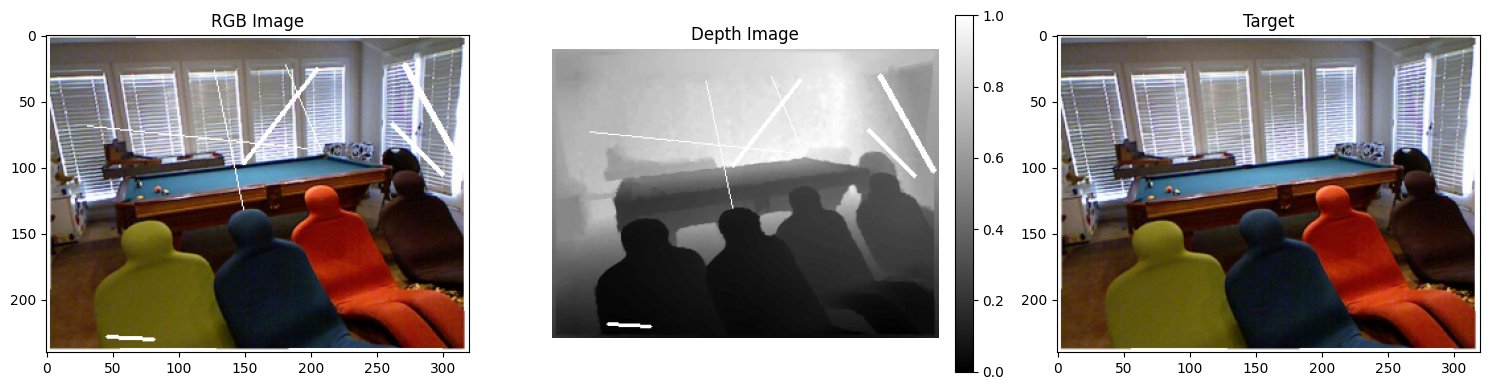

In [8]:
sample_batch = next(iter(train_loader))

print(sample_batch["rgb_input"].shape)            # Should be (batch_size, 4, H, W)
print(sample_batch["depth_input"].shape)          # Should be (batch_size, 3, H, W)
print(sample_batch["target"].shape)               # Should be (batch_size, 1, H, W) 

# Visualize first sample in the batch
show_sample(sample_batch, idx=0)

In [9]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# model = DepthEnhancedInpaintingNet_SimpleAttention().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.L1Loss()

# num_epochs = 20
# best_val_loss = float('inf')
# for epoch in range(1, num_epochs+1):
#     train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
#     val_loss = validate(model, val_loader, criterion, device)
#     print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), "nyu_inpainting_depth_simple_attention.pth")
#         print(f"Saved best model with Val Loss: {best_val_loss:.4f}")

cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 0:
SSD between Inpainted vs GT: 20.464708
SSD between Masked vs GT: 1293.8638


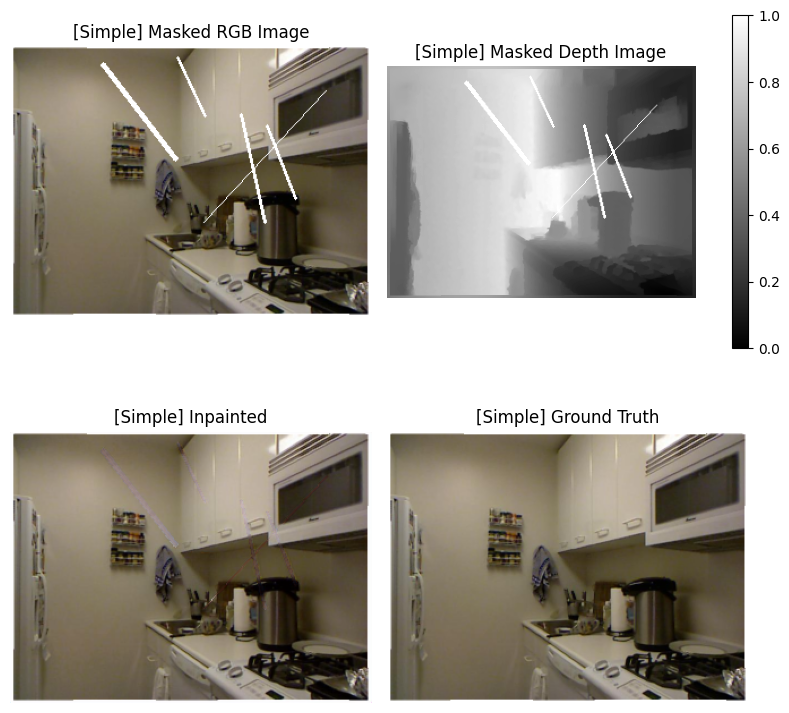

In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = DepthEnhancedInpaintingNet_SimpleAttention().to(device)
model.load_state_dict(torch.load("nyu_inpainting_depth_simple_attention.pth", map_location=device))
model.eval()

# Visualization: select a few samples from the test dataset.
sample_idx = 54
rows = 1
samples = [test_dataset[i] for i in range(sample_idx, sample_idx + rows)]
masked_images = torch.stack([s["rgb_input"] for s in samples], dim=0)
masked_depths = torch.stack([s["depth_input"] for s in samples], dim=0)
sample_labels = torch.stack([s["target"] for s in samples], dim=0)

inpainted_images = []
with torch.no_grad():
    for i in range(rows):
        input_masked = masked_images[i].unsqueeze(0).to(device)
        input_depth  = masked_depths[i].unsqueeze(0).to(device)
        pred = model(input_masked, input_depth)
        inpainted_images.append(pred.squeeze(0).cpu())

plt.figure(figsize=(8, 8))
for i in range(rows):
    masked_np       = masked_images[i].permute(1, 2, 0).cpu().numpy()
    masked_depth_np = masked_depths[i].squeeze(0).cpu().numpy()
    inpainted_np    = inpainted_images[i].permute(1, 2, 0).cpu().numpy()
    gt_color        = sample_labels[i].permute(1, 2, 0).cpu().numpy()

    print(f"Sample {i}:")
    print("SSD between Inpainted vs GT:", np.sum((inpainted_np - gt_color)**2))
    print("SSD between Masked vs GT:", np.sum((masked_np - gt_color)**2))
    
    ax1 = plt.subplot(2, 2, 1)
    ax1.imshow(masked_np)
    ax1.set_title("[Simple] Masked RGB Image")
    ax1.axis("off")

    ax2 = plt.subplot(2, 2, 2)
    im = ax2.imshow(masked_depth_np, cmap="gray", vmin=0, vmax=1)
    ax2.set_title("[Simple] Masked Depth Image")
    ax2.axis("off")
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.1)
    
    ax3 = plt.subplot(2, 2, 3)
    ax3.imshow(inpainted_np)
    ax3.set_title("[Simple] Inpainted")
    ax3.axis("off")
    
    ax4 = plt.subplot(2, 2, 4)
    ax4.imshow(gt_color)
    ax4.set_title("[Simple] Ground Truth")
    ax4.axis("off")

plt.tight_layout()
plt.show()

In [11]:
# from skimage.metrics import structural_similarity  # for SSIM
# import lpips  # for LPIPS

# # Initialize your LPIPS network (using 'alex' backbone, for example)
# loss_fn = lpips.LPIPS(net='alex').to(device)

# # Initialize accumulators for all metrics
# ssd_inpainted_total = 0.0
# ssd_masked_total    = 0.0
# psnr_inpainted_total = 0.0
# psnr_masked_total    = 0.0
# ssim_inpainted_total = 0.0
# ssim_masked_total    = 0.0
# lpips_inpainted_total = 0.0
# lpips_masked_total    = 0.0
# num_images = 0

# model.eval()
# with torch.no_grad():
#     for batch in tqdm(test_loader):
#         # Get inputs and targets from the batch
#         rgb_input   = batch["rgb_input"].to(device)
#         depth_input = batch["depth_input"].to(device)
#         gt          = batch["target"].to(device)
        
#         # Get the model prediction
#         pred = model(rgb_input, depth_input)
        
#         # Compute LPIPS on the batch.
#         # The LPIPS network returns a tensor of shape (batch, 1, 1, 1); we average per image.
#         lpips_inpainted_batch = loss_fn(pred, gt)
#         lpips_masked_batch    = loss_fn(rgb_input, gt)

#         # Sum the per-image LPIPS values across the batch
#         lpips_inpainted_total += lpips_inpainted_batch.mean(dim=[1,2,3]).sum().item()
#         lpips_masked_total    += lpips_masked_batch.mean(dim=[1,2,3]).sum().item()
        
#         # Convert tensors to numpy arrays for computing SSD, PSNR, and SSIM.
#         # Note: expect shape (B, C, H, W); if your images are normalized, max value is 1.0.
#         pred_np   = pred.cpu().numpy()
#         masked_np = rgb_input.cpu().numpy()
#         gt_np     = gt.cpu().numpy()
        
#         batch_size = pred_np.shape[0]
#         for i in range(batch_size):
#             # Compute SSD for inpainted and masked images
#             ssd_inpainted = np.sum((pred_np[i] - gt_np[i])**2)
#             ssd_masked    = np.sum((masked_np[i] - gt_np[i])**2)
#             ssd_inpainted_total += ssd_inpainted
#             ssd_masked_total    += ssd_masked
            
#             # Compute PSNR; here we assume images are in range [0, 1]
#             mse_inpainted = np.mean((pred_np[i] - gt_np[i])**2)
#             mse_masked    = np.mean((masked_np[i] - gt_np[i])**2)
#             psnr_inpainted = 20 * np.log10(1.0 / np.sqrt(mse_inpainted)) if mse_inpainted > 0 else float('inf')
#             psnr_masked    = 20 * np.log10(1.0 / np.sqrt(mse_masked)) if mse_masked > 0 else float('inf')
#             psnr_inpainted_total += psnr_inpainted
#             psnr_masked_total    += psnr_masked
            
#             # For SSIM computation, convert image from (C, H, W) to (H, W, C)
#             pred_img   = np.transpose(pred_np[i], (1, 2, 0))
#             gt_img     = np.transpose(gt_np[i], (1, 2, 0))
#             masked_img = np.transpose(masked_np[i], (1, 2, 0))
            
#             # Compute SSIM; set multichannel=True for color images
#             data_range = gt_img.max() - gt_img.min()
#             ssim_inpainted = structural_similarity(pred_img, gt_img, data_range=data_range, channel_axis=-1)
#             ssim_masked    = structural_similarity(masked_img, gt_img, data_range=data_range, channel_axis=-1)
#             ssim_inpainted_total += ssim_inpainted
#             ssim_masked_total    += ssim_masked
        
#         num_images += batch_size

# # Average the metrics over the entire test dataset
# avg_ssd_inpainted   = ssd_inpainted_total   / num_images
# avg_ssd_masked      = ssd_masked_total      / num_images
# avg_psnr_inpainted  = psnr_inpainted_total  / num_images
# avg_psnr_masked     = psnr_masked_total     / num_images
# avg_ssim_inpainted  = ssim_inpainted_total  / num_images
# avg_ssim_masked     = ssim_masked_total     / num_images
# avg_lpips_inpainted = lpips_inpainted_total / num_images
# avg_lpips_masked    = lpips_masked_total    / num_images

# # Print out all four metrics for both the inpainted output and the masked input
# print("Average SSD (Inpainted vs GT):", avg_ssd_inpainted)
# print("Average SSD (Masked vs GT):", avg_ssd_masked)
# print("Ratio of Inpainted to Masked SSD:", avg_ssd_inpainted / avg_ssd_masked)

# print("\nAverage PSNR (Inpainted vs GT):", avg_psnr_inpainted)
# print("Average PSNR (Masked vs GT):", avg_psnr_masked)
# print("Ratio of Inpainted to Masked PSNR:", avg_psnr_inpainted / avg_psnr_masked)

# print("\nAverage SSIM (Inpainted vs GT):", avg_ssim_inpainted)
# print("Average SSIM (Masked vs GT):", avg_ssim_masked)
# print("Ratio of Inpainted to Masked SSIM:", avg_ssim_inpainted / avg_ssim_masked)

# print("\nAverage LPIPS (Inpainted vs GT):", avg_lpips_inpainted)
# print("Average LPIPS (Masked vs GT):", avg_lpips_masked)
# print("Ratio of Inpainted to Masked LPIPS:", avg_lpips_inpainted / avg_lpips_masked)


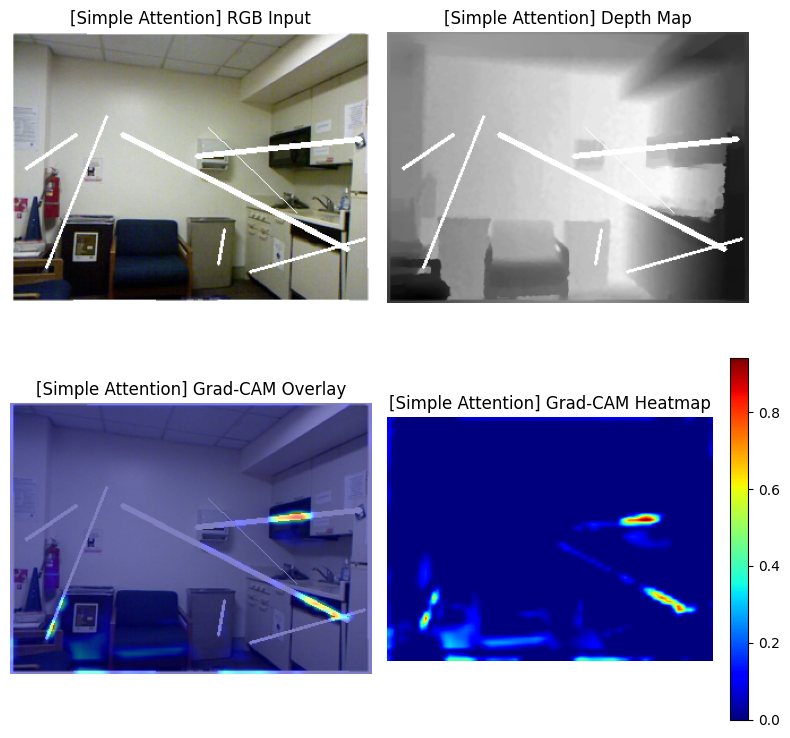

In [12]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.activations = None
        self.gradients = None
        # Capture activations
        target_layer.register_forward_hook(
            lambda m, i, o: setattr(self, 'activations', o.detach())
        )
        # Capture gradients
        target_layer.register_full_backward_hook(
            lambda m, grad_in, grad_out: setattr(self, 'gradients', grad_out[0].detach())
        )

    def __call__(self, x):
        # Split input into RGB and depth
        rgb, depth = x[:, :3], x[:, 3:4]
        # Forward pass
        out = self.model(rgb, depth)
        # Use the global mean of the output as the target score
        score = out.mean()
        self.model.zero_grad()
        score.backward()

        # Compute weights: global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
        # Weighted sum of activations
        cam = F.relu((weights * self.activations).sum(dim=1))[0]  # [H', W']

        # Normalize and resize to input size
        cam = cam.cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.resize(cam, (x.size(3), x.size(2)))
        return cam

# --- Usage Example ---
# Assume `model` (DepthEnhancedInpaintingNet_SimpleAttention) and `test_dataset` are already loaded

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hook the last conv layer in the RGB encoder
target_layer = model.rgb_encoder.blocks[-1][3]
gradcam = GradCAM(model.to(device), target_layer)

# Prepare a single sample
sample = test_dataset[0]
rgb = sample['rgb_input'].unsqueeze(0).to(device)
depth = sample['depth_input'].unsqueeze(0).to(device)
inp = torch.cat([rgb, depth], dim=1)  # [1, 4, H, W]

# Generate CAM
heatmap = gradcam(inp)

# Prepare images for display
img_rgb = rgb[0].permute(1, 2, 0).cpu().numpy()
# Depth map: take the single channel
img_depth = depth[0, 0].cpu().numpy()
# Create color heatmap overlay
jet = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB) / 255.0

# Plot RGB, Depth, and Grad-CAM side by side with colorbar for third subplot
plt.figure(figsize=(8, 8))

# 1) RGB Input
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(img_rgb)
ax1.set_title('[Simple Attention] RGB Input')
ax1.axis('off')

# 2) Depth Map
ax2 = plt.subplot(2, 2, 2)
ax2.imshow(img_depth, cmap='gray')
ax2.set_title('[Simple Attention] Depth Map')
ax2.axis('off')

# 3) Grad-CAM Overlay (blended)
ax3 = plt.subplot(2, 2, 3)
ax3.imshow(0.5 * img_rgb + 0.5 * jet)
ax3.set_title('[Simple Attention] Grad-CAM Overlay')
ax3.axis('off')

# 4) Grad-CAM Overlay (raw heatmap)
ax4 = plt.subplot(2, 2, 4)
im4 = ax4.imshow(heatmap, cmap='jet')
ax4.set_title('[Simple Attention] Grad-CAM Heatmap')
ax4.axis('off')
# Add colorbar
plt.colorbar(im4, ax=ax4, fraction=0.05, pad=0.05)

plt.tight_layout()
plt.show()
